# MNIST Classification
### Zein Alabedeen Barhoum

### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import SGD


import torchvision
from torchvision.models import vgg16, VGG16_Weights
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, Resize, RandomRotation, RandomAdjustSharpness, RandAugment, ColorJitter

#Check for GPU availability
print(torch.__version__)
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

2.0.0+cu118
True
Using cuda device


### Datasets preparation
For augmentation, three separate random transforms were used
1. Random rotation: the maximum rotation was set to 15 degrees
2. Random sharpness adjustment
3. Random color jitter including random brightness, contrast and saturation adjustments
The augmentation was applied to the train dataset, for the validation, only the base transforms were applied that include gray to RGB transform and normalization

In [ ]:
base_transforms = [ToTensor(),
                   Lambda(lambda x: torch.cat([x,x,x], dim=0)),
                #    Resize((32,32),antialias=True),
                   ]
aug_tranforms = [RandomRotation(15),
                 RandomAdjustSharpness(10),
                #  ColorJitter(brightness=[0.5,2]),
                 ColorJitter(brightness=[0.5,2], contrast= [0.5,5], saturation= [0.5,2]),
                 ]
norm_tranform = [Normalize((0.1307,0.1307,0.1307), (0.3081,0.3081,0.3081))]

train_transform = Compose([*base_transforms,*aug_tranforms,*norm_tranform])
valid_transform = Compose([*base_transforms,*norm_tranform])

train_dataset_no_aug = MNIST(root= './',
                      train= True,
                      download= True,
                      transform= valid_transform,
                      )
train_dataset = MNIST(root= './',
                      train= True,
                      download= True,
                      transform= train_transform,
                      )
valid_dataset = MNIST(root= './',
                      train= False,
                      download= True,
                      transform= valid_transform,
                      )

100%|██████████| 9912422/9912422 [00:00<00:00, 141183480.18it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 113849336.30it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37764310.07it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 20729628.69it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



The images drawn from the datasets would be normalized, to plot them, a reverse normalization function was used which reverse the scaling first and then reverse the mean translation.

In [ ]:
def denormalize(img):
    '''
    A function for reverse the normalization of the images for plotting
    '''
    ReverseNormalize = Compose([Normalize((0.0,0.0,0.0), (1/0.3081,1/0.3081,1/0.3081)),
                                Normalize((-0.1307,-0.1307,-0.1307), (1.0,1.0,1.0)),
                            ])
    return np.round(ReverseNormalize(img),5)


Here we can see an image from the train dataset with 5 version of augmentation.

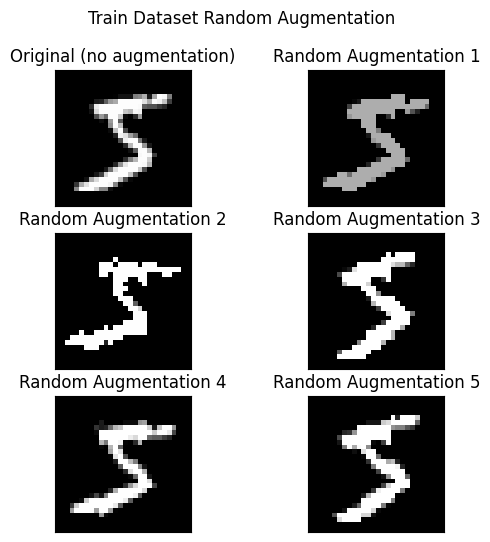

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.suptitle('Train Dataset Random Augmentation')
plt.subplot(3,2,1)
plt.imshow(denormalize(train_dataset_no_aug[0][0]).permute(1,2,0))
plt.title(f'Original (no augmentation)')
plt.xticks([])
plt.yticks([])

for i in range(5):
    plt.subplot(3,2,i+2)
    plt.imshow(denormalize(train_dataset[0][0]).permute(1,2,0))
    plt.title(f'Random Augmentation {i+1}')
    plt.xticks([])
    plt.yticks([])

Here we see examples from the validation dataset with their correct labels

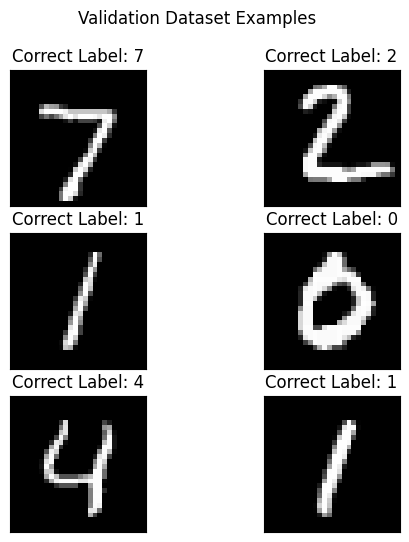

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.suptitle('Validation Dataset Examples')
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(denormalize(valid_dataset[i][0]).permute(1,2,0))
    plt.title(f'Correct Label: {valid_dataset[i][1]}')
    plt.xticks([])
    plt.yticks([])

The datasets are converted to generators (loaders) with batch size 16

In [ ]:
batch_size = 16
train_loader = DataLoader(dataset= train_dataset,
                          batch_size= batch_size,
                          shuffle= True,
                          num_workers= 3
                          )
valid_loader = DataLoader(dataset= valid_dataset,
                          batch_size= batch_size,
                          shuffle= True,
                          num_workers= 3
                          )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing the loaders, we can see the augmentation effect on the train dataloader

content shape: torch.Size([16, 3, 28, 28])
target shape: torch.Size([16])
content shape: torch.Size([16, 3, 28, 28])
target shape: torch.Size([16])


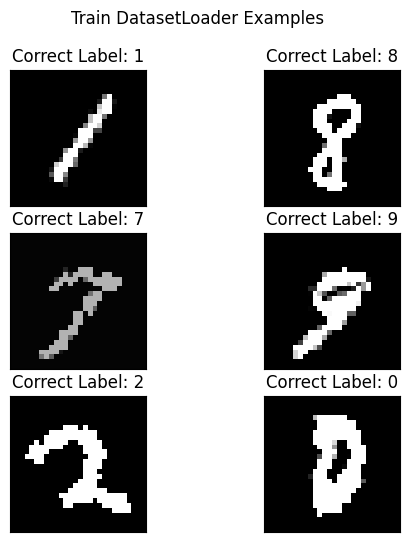

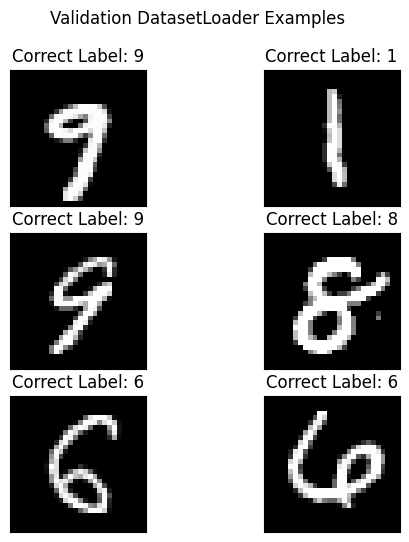

In [ ]:
def test_loader(dataloader,name=''):
    batch_imgs, batch_labels = next(iter(dataloader))
    print(f'content shape: {batch_imgs.shape}')
    print(f'target shape: {batch_labels.shape}')

    fig = plt.figure(figsize=(6,6))
    fig.suptitle(f'{name} DatasetLoader Examples')
    for i in range(6):
        plt.subplot(3,2,i+1)
        plt.imshow(denormalize(batch_imgs[i]).permute(1,2,0))
        plt.title(f'Correct Label: {batch_labels[i]}')
        plt.xticks([])
        plt.yticks([])
test_loader(train_loader,'Train')
test_loader(valid_loader,'Validation')

### Building the model
For the feature extractor, I used the VGG16 model. The classifier was removed and replaced with custom classifier with 3 fully connected layers.

In [ ]:
class VGG_BASED_MODEL(nn.Module):
    def __init__(self):
        vgg_model = vgg16(VGG16_Weights.DEFAULT)
        super().__init__()
        self.resize = Resize((32,32), antialias=True)
        self.flatten = nn.Flatten()
        self.feature_extractor = nn.Sequential(*list(vgg_model.children())[:-1])
        self.classifier = nn.Sequential(*[
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 10), # 10 classes
        ])
    def forward(self, img):
        img = self.resize(img) #resized image
        features = self.feature_extractor(img) #feature extraction
        features = self.flatten(features) #feature vector
        out = self.classifier(features) #logits
        return out

model = VGG_BASED_MODEL().to(device)
inp = torch.randn((16,3,32,32)).to(device)
out = model(inp)
print(f'input shape: {inp.shape}')
print(f'output shape: {out.shape}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 148MB/s]


input shape: torch.Size([16, 3, 32, 32])
output shape: torch.Size([16, 10])


### Training
The SGD optimizer was used for this task. The loss function used is the cross entropy.

In [ ]:
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9)
loss_fun = nn.CrossEntropyLoss()

The training function train the model and update the parameters, the loss and accuracy over the whole train-set is returned after each epoch.

The evaluation passes over the data of the given loader and calculates the total loss and accuracy


In [ ]:
def train_model(epoch_id, print_steps=10):
    model.train()
    done = 0
    train_losses = []
    total_loss = 0
    total_correct = 0

    for batch_num, (batch_imgs, batch_labels) in enumerate(train_loader):
        optimizer.zero_grad()

        inp = batch_imgs.to(device)
        logits = model(inp)
        y_true = batch_labels.to(device)
        y_pred = logits.argmax(dim=1)

        loss = loss_fun(logits, y_true)
        train_losses.append(loss.item())

        total_loss+=loss.item()

        correct = torch.eq(y_pred,y_true).sum().item()
        total_correct += correct

        loss.backward()
        optimizer.step()

        done_percentage = 100*batch_num/(len(train_loader)-1)
        if(done_percentage>= done):
            done+=print_steps
            print(f'Training: epoch: {epoch_id} [{done_percentage:.2f}%], batch_loss: {loss.item():.4f}')
    total_loss = total_loss/len(train_loader)
    total_accuracy = 100*total_correct/len(train_loader.dataset)
    print(f'Training: epoch: {epoch_id} [Finished], loss: {total_loss:.4f}, accuracy: {total_accuracy:.2f}%')

    return (total_loss, total_accuracy)

def evaluate_model(epoch_id, loader=valid_loader, name='Validation'):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for batch_num, (batch_imgs, batch_labels) in enumerate(loader):

            inp = batch_imgs.to(device)
            logits = model(inp)

            y_true = batch_labels.to(device)
            y_pred = logits.argmax(dim=1)

            loss = loss_fun(logits, y_true)
            total_loss+= loss.item()
            correct = torch.eq(y_pred,y_true).sum().item()
            total_correct += correct
    total_loss = total_loss/len(loader)
    total_accuracy = 100*total_correct/len(loader.dataset)
    print(f'{name}: epoch: {epoch_id}, loss {total_loss:.4f}, accuracy: {total_accuracy:.2f}%')

    return (total_loss, total_accuracy)


The model was trained for 3 epoches, an initial evaluation of the model on the training and validation datasets was conducted for plotting purposes.

In [ ]:
import timeit
start_time = timeit.default_timer()

epoches = 3

train_losses =[]
train_accuracies =[]

valid_losses = []
valid_accuracies = []

train_loss,train_accuracy = evaluate_model(0, train_loader, 'Initial Training')
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

valid_loss,valid_accuracy = evaluate_model(0, valid_loader, 'Initial Validation')
valid_losses.append(valid_loss)
valid_accuracies.append(valid_accuracy)

for epoch in range(epoches):

    train_loss,train_accuracy = train_model(epoch+1)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    valid_loss,valid_accuracy = evaluate_model(epoch+1)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

elapsed = timeit.default_timer() - start_time
print(f'Total Training Time {elapsed:2f}s')

Initial Training: epoch: 0, loss 2.3066, accuracy: 9.56%
Initial Validation: epoch: 0, loss 2.3132, accuracy: 9.55%
Training: epoch: 1 [0.00%], batch_loss: 2.4157
Training: epoch: 1 [10.00%], batch_loss: 0.1041
Training: epoch: 1 [20.01%], batch_loss: 0.0349
Training: epoch: 1 [30.01%], batch_loss: 0.1703
Training: epoch: 1 [40.01%], batch_loss: 0.0025
Training: epoch: 1 [50.01%], batch_loss: 0.0800
Training: epoch: 1 [60.02%], batch_loss: 0.0664
Training: epoch: 1 [70.02%], batch_loss: 0.2724
Training: epoch: 1 [80.02%], batch_loss: 0.0043
Training: epoch: 1 [90.02%], batch_loss: 0.1382
Training: epoch: 1 [100.00%], batch_loss: 0.0066
Training: epoch: 1 [Finished], loss: 0.1750, accuracy: 95.37%
Validation: epoch: 1, loss 0.0302, accuracy: 99.26%
Training: epoch: 2 [0.00%], batch_loss: 0.0078
Training: epoch: 2 [10.00%], batch_loss: 0.0073
Training: epoch: 2 [20.01%], batch_loss: 0.0137
Training: epoch: 2 [30.01%], batch_loss: 0.0009
Training: epoch: 2 [40.01%], batch_loss: 0.0586
Tra

### Results Visualization

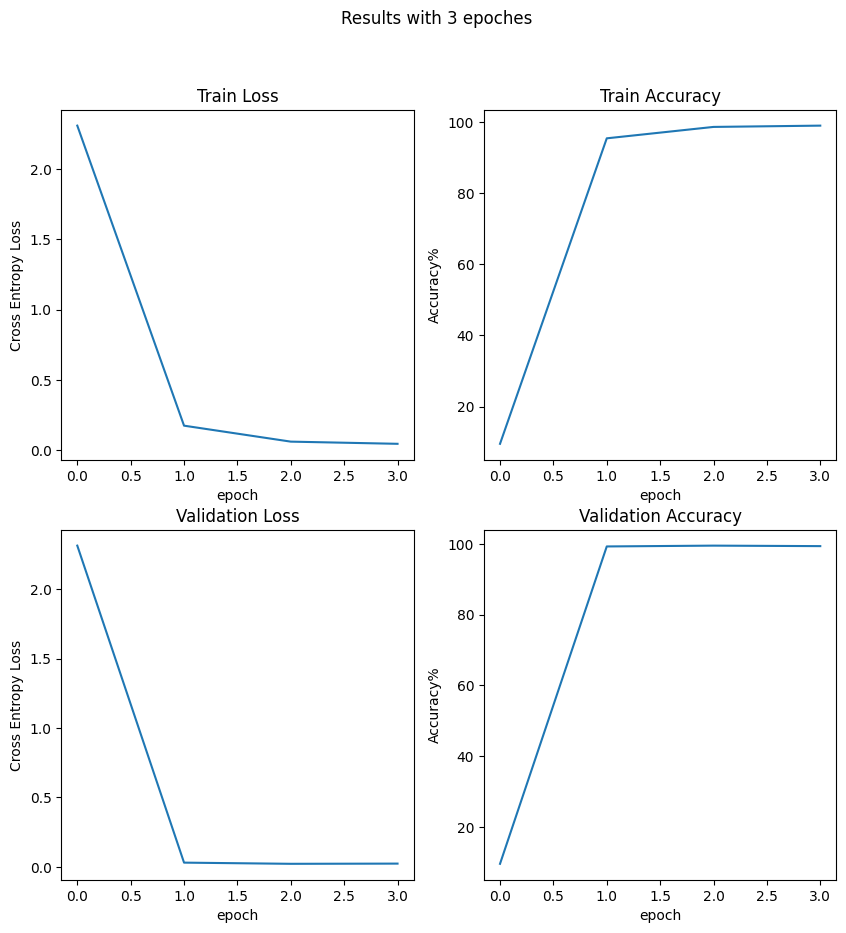

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.suptitle(f'Results with {epoches} epoches')
plt.subplot(2,2,1)
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Train Loss')
plt.subplot(2,2,2)
plt.plot(train_accuracies)
plt.xlabel('epoch')
plt.ylabel('Accuracy%')
plt.title('Train Accuracy')
plt.subplot(2,2,3)
plt.plot(valid_losses)
plt.xlabel('epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Validation Loss')
plt.subplot(2,2,4)
plt.plot(valid_accuracies)
plt.xlabel('epoch')
plt.ylabel('Accuracy%')
plt.title('Validation Accuracy')
plt.show()

### Examples of prediction
6 samples from the validation dataset were selected randomly and the prediction of the model was compared to the true labels.

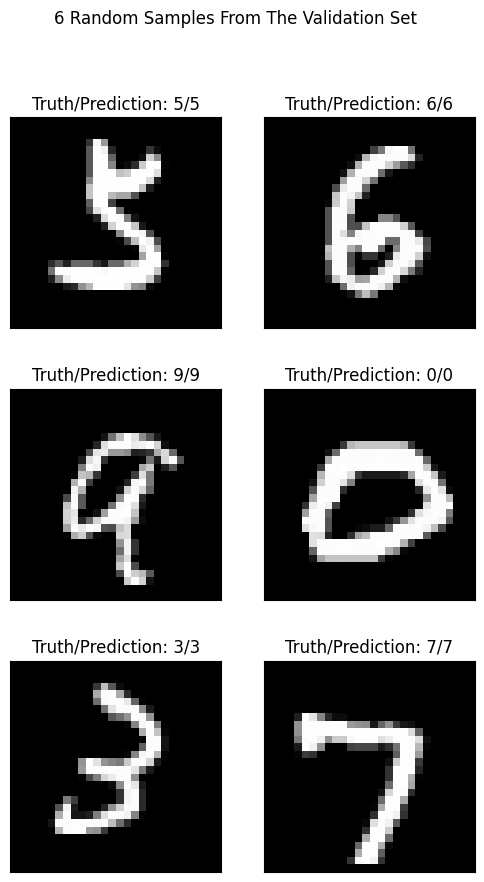

In [ ]:
def plot_img_label(img,true_label):
    inp = img[None,:].to(device)
    out = model(inp)
    pred = out.argmax().item()
    plt.imshow(denormalize(img).permute(1,2,0))
    plt.title(f'Truth/Prediction: {true_label}/{pred}')
    plt.xticks([])
    plt.yticks([])

fig = plt.figure(figsize=(6,10))
fig.suptitle('6 Random Samples From The Validation Set')
for i, ind in enumerate(np.random.randint(0,len(valid_dataset),size=6)):
    plt.subplot(3,2,i+1)
    plot_img_label(valid_dataset[ind][0],valid_dataset[ind][1])


### External Testing
To further test the model beyond the MNIST dataset, I created six 64 by 64 images using [the drawing website](https://www.pixilart.com/draw) and used the model to predict the label

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


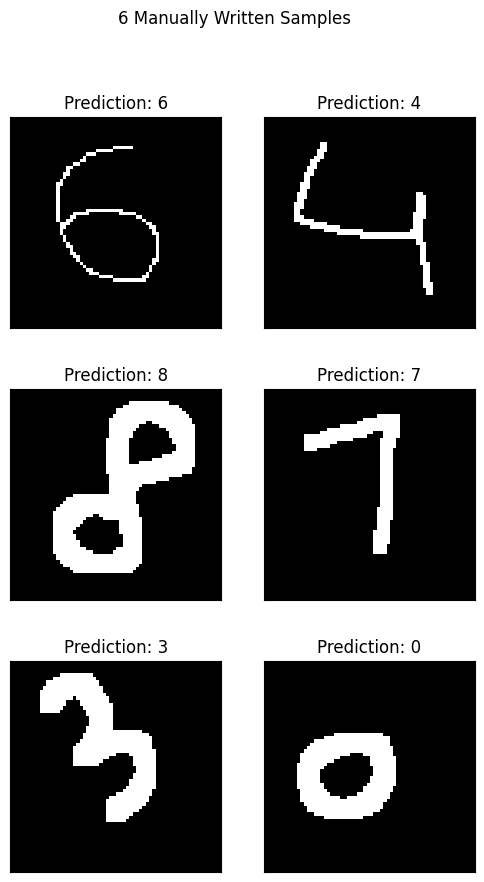

In [ ]:
def external_test(img):
    inp = img[None,:].to(device)
    out = model(inp)
    pred = out.argmax().item()
    plt.imshow(denormalize(img).permute(1,2,0))
    plt.title(f'Prediction: {pred}')
    plt.xticks([])
    plt.yticks([])

n_tests = 6
fig = plt.figure(figsize=(6,10))
fig.suptitle('6 Manually Written Samples')

for i in range(n_tests):
    img = plt.imread(f'/content/drive/MyDrive/Colab Notebooks/Machine Learning/Lab1/tests/test{i+1}.png')
    gray_img = img[:,:,3]
    ready_img = valid_transform(gray_img)
    plt.subplot(int(np.ceil(n_tests/2)),2,i+1)
    external_test(ready_img)

